In [1]:
!pip install torch
!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [2]:
import pandas as pd
import numpy as np
# 读取上传的 CSV 文件
file1_path = "/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
file2_path = "/content/TRAINING_SOLUTIONS.xlsx"
file3_path = "/content/TRAIN_QUANTITATIVE_METADATA_imputed.xlsx"
file4_path = "/content/Corrected_Filled_TEST_Data.csv"
file5_path = "/content/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
file6_path = "/content/TRAIN_CATEGORICAL_METADATA_imputed.xlsx"
file7_path = "/content/Imputed_Test_Data.csv"
df1 = pd.read_csv(file1_path)
df2 = pd.read_excel(file2_path)
df3 = pd.read_excel(file3_path)
df4 = pd.read_csv(file4_path)
df5 = pd.read_csv(file5_path)
df6 = pd.read_excel(file6_path)
df7 = pd.read_csv(file7_path)

# 按照 df1 (结果.csv) 中的 participant_id 顺序重新排序 df2 (first_four_rows.csv)
df2_sorted = df2.set_index("participant_id").reindex(df1["participant_id"]).reset_index()
df3_sorted = df3.set_index("participant_id").reindex(df1["participant_id"]).reset_index()
d6_sorted = df6.set_index("participant_id").reindex(df1["participant_id"]).reset_index()

#这里是 1是gender 0就是adhd
label= df2_sorted.iloc[:, 1].to_numpy()
#这是quantitive data
feature=df3_sorted.iloc[:, 1:18].to_numpy()
test_feature=df4.iloc[:, 1:18].to_numpy()
#这是cata data
cata= d6_sorted.iloc[:, 1:].to_numpy()
test_cata=df7.iloc[:, 1:].to_numpy()
#feature=np.concatenate((feature, cata), axis=1)
#test_feature=np.concatenate((test_feature, test_cata), axis=1)

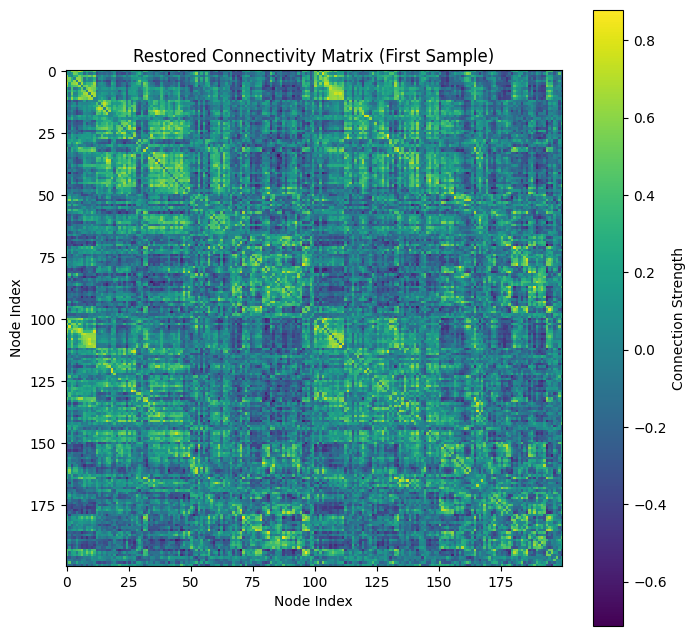

In [3]:
def compute_matrix_size(num_columns):

    N = int((1 + np.sqrt(1 + 8 * num_columns)) / 2)
    return N

def restore_symmetric_matrix(upper_tri_values, N):


    matrix = np.zeros((N, N))  # 先填充全 0
    upper_triangle_indices = np.triu_indices(N, k=1)  # 获取上三角索引
    matrix[upper_triangle_indices] = upper_tri_values  # 赋值上三角
    matrix += matrix.T  # 复制上三角到下三角，得到对称矩阵
    return matrix

def process_connectivity_data(file_path):

    # 读取 CSV 数据
    data = pd.read_csv(file_path)

    # 计算矩阵大小 N
    num_columns = data.shape[1] - 1  # 第一列是 participant_id
    N = compute_matrix_size(num_columns)

    # 处理所有行数据，转换为对称矩阵
    restored_matrices = []
    for _, row in data.iloc[:, 1:].iterrows():
        restored_matrix = restore_symmetric_matrix(row.values, N)
        restored_matrices.append(restored_matrix)

    return restored_matrices

# 示例使用
file_path = "/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"  # 替换为你的文件路径
restored_matrices = process_connectivity_data(file_path)
test_restored_matrices = process_connectivity_data("/content/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
# 显示第一个还原的矩阵
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(restored_matrices[4], cmap='viridis', interpolation='nearest')
plt.colorbar(label="Connection Strength")
plt.title("Restored Connectivity Matrix (First Sample)")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

In [4]:
import os
import numpy as np
import pickle
import torch



#读取所有矩阵文件
matrix_files = restored_matrices # 确保文件顺序一致
labels = label  # 加载标签，假设是 numpy 数组
features = feature / feature.max(axis=0)
assert len(matrix_files) == len(labels), "矩阵数量和标签数量不匹配！"

Data_list = []

#处理每个矩阵，转换为 `data_list` 结构
for i in range(len(restored_matrices)):
    adj_matrix = restored_matrices[i]   # 200x200 邻接矩阵
    label = labels[i]# 读取对应的标签
    feature = features[i]
    deg = (np.abs(adj_matrix) > 0.01).sum(1).astype(np.float32)
    node_feat = deg.reshape(-1, 1)
    # 确保邻接矩阵是 200x200
    assert adj_matrix.shape == (200, 200), f"矩阵 {file_name} 不是 200x200 形状！"

    Data_list.append({"adj": adj_matrix, "label": label, "feature": feature,"node_featue":node_feat})

#保存 `data_list` 供后续训练
with open("Data.pkl", "wb") as f:
    pickle.dump(Data_list, f)

print(f"数据处理完成！已保存 {len(Data_list)} 个图数据到 'data.pkl'")
len(Data_list)

数据处理完成！已保存 1213 个图数据到 'data.pkl'


1213

In [5]:
import os
import numpy as np
import pickle
import torch



#读取所有矩阵文件
matrix_files = test_restored_matrices # 确保文件顺序一致
labels = np.ones(len(test_restored_matrices)) # 加载标签，假设是 numpy 数组
features = test_feature / test_feature.max(axis=0)
assert len(matrix_files) == len(labels), "矩阵数量和标签数量不匹配！"

Test_Data_list = []

#处理每个矩阵，转换为 `data_list` 结构
for i in range(len(test_restored_matrices)):
    adj_matrix = restored_matrices[i]   # 200x200 邻接矩阵
    label = labels[i]# 读取对应的标签
    feature = features[i]
    deg = (np.abs(adj_matrix) > 0.01).sum(1).astype(np.float32)
    node_feat = deg.reshape(-1, 1)
    # 确保邻接矩阵是 200x200
    assert adj_matrix.shape == (200, 200), f"矩阵 {file_name} 不是 200x200 形状！"

    Test_Data_list.append({"adj": adj_matrix, "label": label, "feature": feature,"node_featue":node_feat})

#保存 `data_list` 供后续训练
with open("Test_Data.pkl", "wb") as f:
    pickle.dump(Test_Data_list, f)

print(f" 数据处理完成！已保存 {len(Test_Data_list)} 个图数据到 'data.pkl'")
len(Test_Data_list)

 数据处理完成！已保存 304 个图数据到 'data.pkl'


304

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
from torch_geometric.nn import TopKPooling, SAGPooling
import torch.nn as nn

def create_pyg_data(graphs, num_lap_features=10, threshold=0.03):
    data_list = []
    for graph in graphs:
        adj_matrix = graph['adj']      # Adjacency matrix, shape (num_nodes, num_nodes)
        label = graph['label']         # Graph label
        feature = graph['feature']     # Extra graph-level features (e.g., 17 dimensions)
        x = graph['node_featue']

        x = torch.tensor(x, dtype=torch.float32)
        # Process the adjacency matrix based on the threshold: positions with absolute value greater than threshold are kept as True
        filtered_adj = np.abs(adj_matrix) > threshold

        # Get the indices of edges that satisfy the condition (nonzero indices)
        edge_index = torch.tensor(
            np.array(np.nonzero(filtered_adj)).astype(np.int64),
            dtype=torch.long
        )

        y = torch.tensor(label, dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y, feature=feature)
        data_list.append(data)
    return data_list



pyg_data_list = create_pyg_data(Data_list)
test_pyg_data_list = create_pyg_data(Test_Data_list)

train_size = int(0.8 * len(pyg_data_list))
val_size = int(0.2 * len(pyg_data_list))
test_size = len(pyg_data_list) - train_size - val_size

train_data = pyg_data_list[:train_size]
val_data = pyg_data_list[train_size:train_size+val_size]
test_data = test_pyg_data_list

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 使用 GCN
class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels=1, hidden_channels=128, num_classes=2, dropout=0.4, pool_ratio=0.5):
        super(GCNGraphClassifier, self).__init__()
        # 第一层 GCNConv
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        # 第二层 GCNConv
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        # 第三层 GCNConv
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm(hidden_channels)


        self.fc1 = nn.Linear(hidden_channels + 17, hidden_channels // 4)
        self.fc2 = nn.Linear(hidden_channels // 4, hidden_channels // 8)
        self.fc3 = nn.Linear(hidden_channels // 8, hidden_channels // 8)
        self.fc4 = nn.Linear(hidden_channels // 8, num_classes)
        self.pool1 = TopKPooling(hidden_channels, ratio=pool_ratio)
        self.pool2 = TopKPooling(hidden_channels, ratio=pool_ratio)

        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch, feature = data.x, data.edge_index, data.batch, data.feature

        # 第一层 GCNConv
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch=batch)
        # 第二层 GCNConv
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch=batch)
        # 第三层 GCNConv
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # 全局池化：得到整个图的表示
        x = global_mean_pool(x, batch)

        # 拼接全局表示和额外特征（确保 feature 的设备与 x 一致）
        x = torch.cat((x, torch.tensor(feature, dtype=torch.float32, device=x.device)), dim=1)

        # MLP 分类头部
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        out = self.fc4(x)
        return out

# 初始化模型、优化器、损失函数和学习率调度器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GCNGraphClassifier(in_channels=1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


def train_one_epoch(loader):
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for data in loader:
        data = data.to(device)

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total_samples += data.num_graphs

    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    return avg_loss, accuracy

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total_samples += data.num_graphs

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = correct / total_samples if total_samples > 0 else 0
    return avg_loss, accuracy

def predict(loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    return all_preds

# 训练循环及早停机制
num_epochs = 50
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 1000  # 如果连续 early_stop_patience 轮验证损失没有提升，则提前停止

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(train_loader)
    val_loss, val_acc = evaluate(val_loader)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"LR: {scheduler.get_last_lr()}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # 保存模型参数（可选）
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping triggered.")
            break

# 测试评估
test_loss, test_acc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
test_preds = predict(test_loader)
print("Test predictions:", test_preds)

Using device: cuda
Epoch [1/50] Train Loss: 0.6748, Train Acc: 0.5938 | Val Loss: 3.0095, Val Acc: 0.6736 | LR: [0.005]
Epoch [2/50] Train Loss: 0.6315, Train Acc: 0.6784 | Val Loss: 3.3645, Val Acc: 0.6736 | LR: [0.005]
Epoch [3/50] Train Loss: 0.6355, Train Acc: 0.6804 | Val Loss: 1.4309, Val Acc: 0.6736 | LR: [0.005]
Epoch [4/50] Train Loss: 0.6142, Train Acc: 0.6938 | Val Loss: 1.3869, Val Acc: 0.6736 | LR: [0.005]
Epoch [5/50] Train Loss: 0.6193, Train Acc: 0.6887 | Val Loss: 0.6255, Val Acc: 0.6736 | LR: [0.005]
Epoch [6/50] Train Loss: 0.5951, Train Acc: 0.6887 | Val Loss: 0.8799, Val Acc: 0.6736 | LR: [0.005]
Epoch [7/50] Train Loss: 0.5824, Train Acc: 0.6887 | Val Loss: 0.6192, Val Acc: 0.6736 | LR: [0.005]
Epoch [8/50] Train Loss: 0.5628, Train Acc: 0.6897 | Val Loss: 0.5922, Val Acc: 0.6736 | LR: [0.005]
Epoch [9/50] Train Loss: 0.5684, Train Acc: 0.6876 | Val Loss: 0.6425, Val Acc: 0.6736 | LR: [0.005]
Epoch [10/50] Train Loss: 0.5584, Train Acc: 0.6938 | Val Loss: 0.6072, 